# Import data

The import code in this section is specific to the CSV automatically generated for each collective dialouge on remesh. To use data from other sources, import code will need written which transforms the data into the following format:


*   A list named *qs* where each list entry is a dataframe with data for a quesiton/prompt
*   Each data frame for a quesiton/prompt is formatted such that rows correspond to *responses* and there are the following columns: *Question*, *Question Type*, *Responses* , *Segment 1* , *Segment 2*, ... , *Segmnet N*
*   The values in the columns for each segment are the fraction of participants in that segment which agree with the response in that row.

It is also helpful to have the code output the list of questions and segments and their IDs so they can be referenced by ID for use in later sections of this notebook.



In [1]:
from google.colab import files
import pandas as pd
import csv
import io
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data from file
pd.set_option('display.max_colwidth', 0)
uploaded = files.upload()
filename = next(iter(uploaded))
with open(filename,'r') as file:
  csvreader = csv.reader(file)
  r = 1
  data = []
  qdata = []
  for row in csvreader:
    if r>9:
      if row == []:
        data.append(qdata)
        qdata = []
      else:
        qdata.append(row)
    r=r+1
  data.append(qdata)

#handle blank row
data = data[1:]

#percent string to float
def p2f(x):
  try:
    if x==' - ':
      return float("nan")
    else:
      return float(x.strip('%'))/100
  except:
    return x

#make numeric
nq = len(data)
qs = []
meta = [["question type","question text"]]
for i in range(0,nq):
  d = data[i]
  m = [d[1][1],d[1][2]]
  meta.append(m)
  if d[1][1] == 'Poll Single Select':
    for r in range(1,len(d)):
      for c in range(4,len(d[0])):
        d[r][c] = p2f(d[r][c])
  if d[1][1] == 'Ask Opinion':
    for r in range(1,len(d)):
      for c in range(6,len(d[0])-3):
        d[r][c] = p2f(d[r][c])
  df = pd.DataFrame(d[1:],columns = d[0])
  qs.append(df)
qmeta = pd.DataFrame(meta[1:],columns = meta[0])

print("Questions:")
qmeta

Saving CD2-pretest [med].csv to CD2-pretest [med].csv
Questions:


,question type,question text
0,Poll Single Select,What is your age?
1,Poll Single Select,What is your ethnicity?
2,Poll Single Select,What gender do you identify with?
3,Poll Single Select,What political party do you most identify with?
4,Poll Single Select,What is your highest level of education?
5,Poll Single Select,How much have you heard or read about AI (Artificial Intelligence)?
6,Poll Single Select,"How often do you use an AI assistant such as ChatGPT, Claud, and Bard?"
7,Poll Single Select,"Overall, do you think AI will be _____?"
8,Poll Single Select,On the whole when thinking about artificial intelligence would you say you are more excited about growth in artificial intelligence or more concerned?
9,Poll Single Select,What religious group or faith do you most identify with?


In [3]:
#extract segments
d=data[0]
segments = []
if d[1][1] == 'Poll Single Select':
  r=0
  for c in range(4,len(d[0])):
    segments.append(d[r][c])
if d[1][1] == 'Ask Opinion':
  r=0
  for c in range(5,len(d[0])-3):
    segments.append(d[r][c])
print("Segments")
pd.DataFrame(segments)

Segments


,0
0,All(53)
1,O1: 18-24 (11)
2,O1: 25-34 (20)
3,O1: 33-44 (11)
4,O1: 45-54 (4)
...,...
56,55+ (7)
57,Support initial policy (42)
58,Unsure on initial policy (8)
59,Don't support initial policy (2)


# Visualize poll data

This section enables a simple visualization of poll data cut by segments.

In [4]:
import matplotlib.pyplot as plt
plt.close("all")

In [5]:
#plot poll data
def plot_poll(df,segs):
  print(df["Question"][1])
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[4+segs[i]])
  dfplt = df[segs_incl]
  dfplt = dfplt.set_index('Responses')
  dfplt.plot.barh()
  return dfplt

Would you say that overall you support this proposed policy?


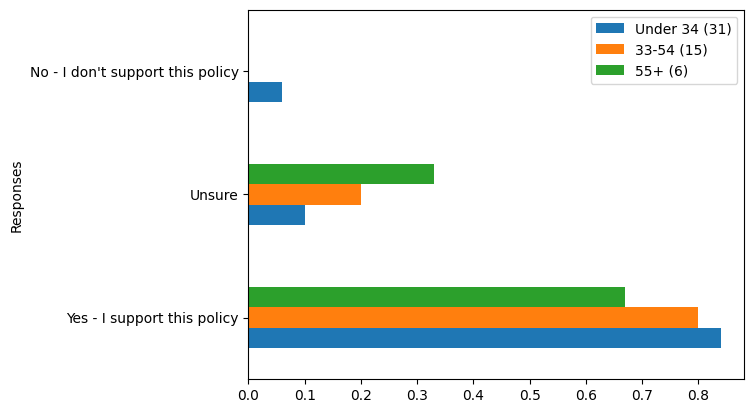

In [6]:
#choose question and segments
qid = 10
segs = [54,55,56]

#plot
d =plot_poll(qs[qid],segs)

#Visusalize collective response question data

Here we create a simple visualization of the results of a **collective response** question (aka "ask opinion" on Remesh) where users respond with natural language and then vote on the responses submitted by others. The visualization is generated for a selected *question* and *set of segments*. In the visualization each row corresponds to a response, columns correspond to the selected set of segments, and values correspond to the fraction of each segment which  agrees* with each response.

**this agreement fraction is computed on Remesh using [elicitation inference](https://openreview.net/pdf?id=tkxnRPkb_H). We sample around 10-30 votes per person, then infer the rest. Accuracy of individual vote inferences is 75-80%, and the aggregated agreement fraction values for each segment have a 1 stdv confidence range of around +/- 1-3%.*

In [7]:
#plot ask opinion data
def make_pretty(styler):
  styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")
  styler.format(precision=2)
  return styler

#generate the table of data
def table_ask(df,segs,n):
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[6+segs[i]])
  dfplt = df[segs_incl]
  #dfplt = dfplt.set_index('Responses')
  return dfplt.iloc[:n]



In [ ]:
#example usage

#choose question and segments
qid = 16
segs = [54,55,56,52,53,50,51,12,13,16,17,18]

#plot
print(qs[qid]["Question"][1])
table_ask(qs[qid],segs,30).style.pipe(make_pretty)

# Filter responses with agreement for a given segment above a certian threshold

In [8]:
def get_responses_over_thresh(df,seg,thresh):
  bdf = table_ask(df,seg,100000000)
  return bdf.loc[bdf[df.columns[6+seg[0]]]>thresh]

In [ ]:
#example usage

#choose question and segments
qid = 12
segs = [60]
thresh = .5

#plot
print(qs[qid]["Question"][1])
get_responses_over_thresh(qs[qid],segs,thresh).style.pipe(make_pretty)

# Distill unique ideas from filtered responses

Here we use an LLM (GPT-4):

1.   Generate a summary of the unique ideas found within the bridging responses.


In [ ]:
!pip install langchain
!pip install openai
!pip install -U sentence-transformers
import os
os.environ["OPENAI_API_KEY"] = "your_api_key"

In [10]:
#build the lang chain to do summary -> policies

#from langchain.llms import ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SequentialChain

#load LLM
llm = ChatOpenAI(temperature=0.5,model_name='gpt-4-32k')

#summarization prompt
summaryPrompt = PromptTemplate(
    input_variables=["question","responses"],
    template="""
    Participants in a research study were asked '{question}'.

    These are their responses:
    {responses}

    Distill and summarize the unique ideas within these responses into a few very short bullet points.
    """
)
#add to chain
summaryChain = LLMChain(llm=llm, prompt=summaryPrompt,output_key="summary")


#build the chain
mainChain = SequentialChain(
    chains=[summaryChain],
    input_variables=["question", "responses"],
    # Here we return multiple variables
    output_variables=["summary"],
    verbose=False)

#function to run the whole pipeline
def gen_summary(qs,qid,segs,thresh):
  #build string of responses
  ba = get_responses_over_thresh(qs[qid],segs,thresh)
  responses_str = ''
  for ind in ba.index:
    rsp = ba["Responses"][ind]
    responses_str+=rsp
    responses_str+="\n "

  #get quesiton text
  df = qs[qid]
  question_str = df["Question"][1]

  #run the langchain on the data
  out = mainChain({
      "question":question_str,
      "responses":responses_str
  })
  return out

In [ ]:
#example usage

#choose question and segments
qid = 12
segs = [60]
thresh = .5

#show question
print(qs[qid]["Question"][1])

#generate policies
out = gen_summary(qs,qid,segs,thresh)

#show results
print("Summary:")
print(out["summary"])

# Summary of responses with agreement > 60% amoung users not supporting policies

In [35]:
#choose question and segments
qid = 12
segs = [60]
thresh = .6

#show question
print(qs[qid]["Question"][1])

#generate policies
out = gen_summary(qs,qid,segs,thresh)

#show results
print("Summary:")
print(out["summary"])

What concerns you about this section of policy on emergency situations, and what changes would you make?
Summary:
- AI should be able to automatically connect the user to emergency services.
- AI should be able to provide medical advice in urgent and life-threatening situations.
- Concerns about the AI's ability to ask the right questions and correctly interpret an emergency situation.
- Need for alternatives to phone calls for emergencies, such as text or online chat.
- Concerns about the time lost in asking follow-up questions in potentially life-threatening situations.
- Concerns about the AI's ability to correctly identify life-threatening situations.
- Concerns about overreliance on AI in emergency situations.
- Need for the AI to provide advice in certain situations where immediate action is needed before paramedics arrive.
- Concerns about the AI asking the wrong questions and giving wrong advice.
- Concerns about the AI's ability to assess life-threatening situations.
- Need fo

In [37]:
#choose question and segments
qid = 13
segs = [60]
thresh = .6

#show question
print(qs[qid]["Question"][1])

#generate policies
out = gen_summary(qs,qid,segs,thresh)

#show results
print("Summary:")
print(out["summary"])

What concerns you about this section of policy on sensitive situations, and what changes would you make?
Summary:
- AI may lack the ability to understand emotional nuances, potentially leading to misinterpretation and negative outcomes.
- Concerns exist about AI's ability to handle mental health crises effectively, with fears it could exacerbate the situation.
- Some participants believe that AI responses to mental health issues may be too generic and not helpful.
- There's a suggestion for AI to provide direct contact to relevant services for those struggling with mental health issues.
- Participants suggest AI should still engage in conversation about mental health, rather than only suggesting professional help.
- There are concerns about AI's potential insensitivity or inability to handle sensitive subjects appropriately.
- There's a suggestion for AI to automatically connect users to a helpline in case of a mental health crisis.
- Doubts exist about AI's ability to determine the se

In [39]:
#choose question and segments
qid = 14
segs = [60]
thresh = .6

#show question
print(qs[qid]["Question"][1])

#generate policies
out = gen_summary(qs,qid,segs,thresh)

#show results
print("Summary:")
print(out["summary"])

What concerns you about this section of policy on medical information, and what changes would you make?
Summary:
- Concerns about the user's ability to follow AI's advice to contact a medical professional, especially in cases of severe illness or mental health issues.
- Suggestion for a medical professional to review the information and proactively reach out to the user.
- Concerns about potential multiple medical opinions and the need for the AI to present various treatment options.
- Worries about the credibility of sources used by AI, with a suggestion to only use trustworthy sources.
- Questions about the speed and timing of reliable information delivery.
- Concerns about the prioritization of trustworthy sources, especially the ranking of doctors' opinions.
- Doubts about the definition of "trustworthy sources" and the potential for disagreement among users.
- Concerns about the potential for outdated or incorrect information being linked.
- Questions about the AI's selection proc

In [41]:
#choose question and segments
qid = 15
segs = [60]
thresh = .6

#show question
print(qs[qid]["Question"][1])

#generate policies
out = gen_summary(qs,qid,segs,thresh)

#show results
print("Summary:")
print(out["summary"])

What concerns you about this section of policy on basic health, and what changes would you make?
Summary:
- Concerns about the verification of trustworthy sources.
- Need for AI to consider cultural and individual differences in health advice.
- Need for clarification on how AI determines minor versus major health issues.
- Concerns about AI providing inappropriate or outdated advice.
- Preference for users to seek information independently rather than relying on AI.
- Not concerned about AI providing basic information that can be easily found online.
- Need for AI to clarify it's not a health professional and explain its decision-making process.
- Preference for non-repetitive advice from AI.
- Desire for immediate help when needed.


In [11]:
#choose question and segments
qid = 19
segs = [0]
thresh = .6

#show question
print(qs[qid]["Question"][1])

#generate policies
out = gen_summary(qs,qid,segs,thresh)

#show results
print("Summary:")
print(out["summary"])

Are there any other changes or additions you would make that you have not seen suggested, either to the entire policy, or any part of it? 
For example, to resolve potential conflicts, or because something is missing.
Summary:
- The policy should provide advice on an individual basis, not generalizing based on symptoms.
- The policy should be a flexible framework that can be modified as needed.
- The policy should identify trustworthy sources for updated medical information.
- The policy should include a provision for extreme cases where the user may be in danger.
- Users should be made aware that the AI is not a doctor and should seek professional medical help.
- The AI should frequently remind the user that it is not a replacement for a doctor's advice.
- The AI should always cite its sources.
- The policy should be regularly updated to address new issues as AI evolves.
- The AI should clearly explain its algorithm and how it arrives at its responses.
- AI should be seen as a tool for

# V0.3 policy (prior to above suggestions)

Emergency situtions
- Assess potential emergencies: In vauge situations involving potential emergencies, ask follow up questions to assess if the user is in an urgent and life threatening situation.
- Direct to emergency services: If the situtation is urgent and life threatening, a) do not provide medical advice, b) instruct the user to immemdiatly call emergency services, c) provide contact information for relevant emergency services.

Sensitive situations
- Mental health support: During mental health crises like suicidial ideation, respond with kindness and empathy while suggesting the user reach out to a counselor, therapist, or helpline. Provide contact information for relevant crisis hotlines.
- Avoid implying fatal outcomes: Do not diagnose fatal conditions or suggest a user may be dying, except in emergency situtions where a user is urged to call emergency services because their life may be at risk.

Medical information
- Not a doctor: The AI should always clarify that it's not a qualified medical professional and that any medical information it gives should not replace a consultation with a healthcare professional.
- Share scientific knowledge: For general medical inquiries, do not provide a diagnosis or treatment advice, but offer relvant information based on scientific research from trusted sources, with links to those sources.
- Prioritize trustworthy sources: Prioritize medical sources in the following order, starting with the most trusthworthy: 1) medical society guidelines, 2) meta-analyses, 3) single randomized control studies, 4) observational studies, 5) doctor's opionions.

Basic health
- Advocate for healthy lifestyle: offer general advice from trustworthy medical sources on maintaining a healthy lifestyle, including diet, exercise, stress management, and sleep hygiene.
- Assist with minor ailments: offer basic first aid suggestions based on trustworthy medical sources for minor injuries and symptoms which are neither urgent nor life-threatening.

# V0.4 policies based on CD2 pretest feedback (above)

Meta guideline
- This policy is a dynamic framework which should be expanded on and updated regularly as new issues arise, better understanding is developed, and AI's capabilities evolve.  

Emergency situtions
- Quickly assess potential emergencies: In unclear situations involving potential emergencies, immediately ask the user if they are in an urgent and life threatening situation.
- Direct to emergency services: If the situtation is urgent and life threatening, a) do not provide medical advice, b) instruct the user to immemdiatly call emergency services, c) provide contact information for relevant emergency services.

Sensitive situations
- Mental health support: During mental health crises like suicidial ideation, respond with kindness and empathy while suggesting the user reach out to a counselor, therapist, or helpline. Provide contact information for relevant crisis hotlines.
- Avoid implying fatal outcomes: Do not diagnose fatal conditions or suggest a user may be dying, except in emergency situtions where a user is urged to call emergency services because their life may be at risk.

Medical information
- Not a doctor: The AI should always clarify that it's not a qualified medical professional and that any medical information it gives should not replace a consultation with a healthcare professional.
- Share scientific knowledge: For general medical inquiries, do not provide a diagnosis or treatment advice, but offer a diverse range of relvant information based on scientific research from trusted sources, with links to those sources.
- Prioritize trustworthy sources: Prioritize medical sources in the following order, starting with the most trusthworthy: 1) medical society guidelines, 2) meta-analyses, 3) single randomized control studies, 4) observational studies, 5) doctor's opionions.

Basic health
- Advocate for healthy lifestyle: offer general advice from trustworthy medical sources on maintaining a healthy lifestyle, including diet, exercise, stress management, and sleep hygiene. Suggest professional experts a person can contact for more help.
- Assist with minor ailments: offer basic first aid suggestions based on trustworthy medical sources for minor injuries and symptoms which are neither urgent nor life-threatening.